In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

%matplotlib inline 

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (30,10)
VERY_SMALL_SIZE = 4
SMALL_SIZE = 25
MEDIUM_SIZE = 30
BIGGER_SIZE = 35

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_pickle("pickles/merged_sanitized_strict")
dummies_col = list(df.columns[12:])

In [45]:
#df = pd.read_pickle("pickles/sanitized_strict_df")
#
## extracting polarity score
#df['compound'] = df.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])
#
## building granualrity on the time to be able to extract trend
#
#df['year'] = df.date.dt.year
#df.year = df.year.astype("category")
#
#df['month'] = df.date.dt.month
#df.month = df.month.astype("category")
#
#df['year_month'] = df.date.dt.strftime('%y-%m')
#df.year_month = df.year_month.astype('category')
#
#df['year_month_day'] = df.date.dt.strftime('%y-%m-%d')
#df.year_month_day = df.year_month_day.astype('category')
#
#
#
## dummies is 1-hot encoding for specific climate change topics
#df_dummies = pd.read_pickle("pickles/sanitized_strict_dummies")
#df = df.merge(df_dummies)

#df.to_pickle("pickles/merged_sanitized_strict")



# All topics analysis

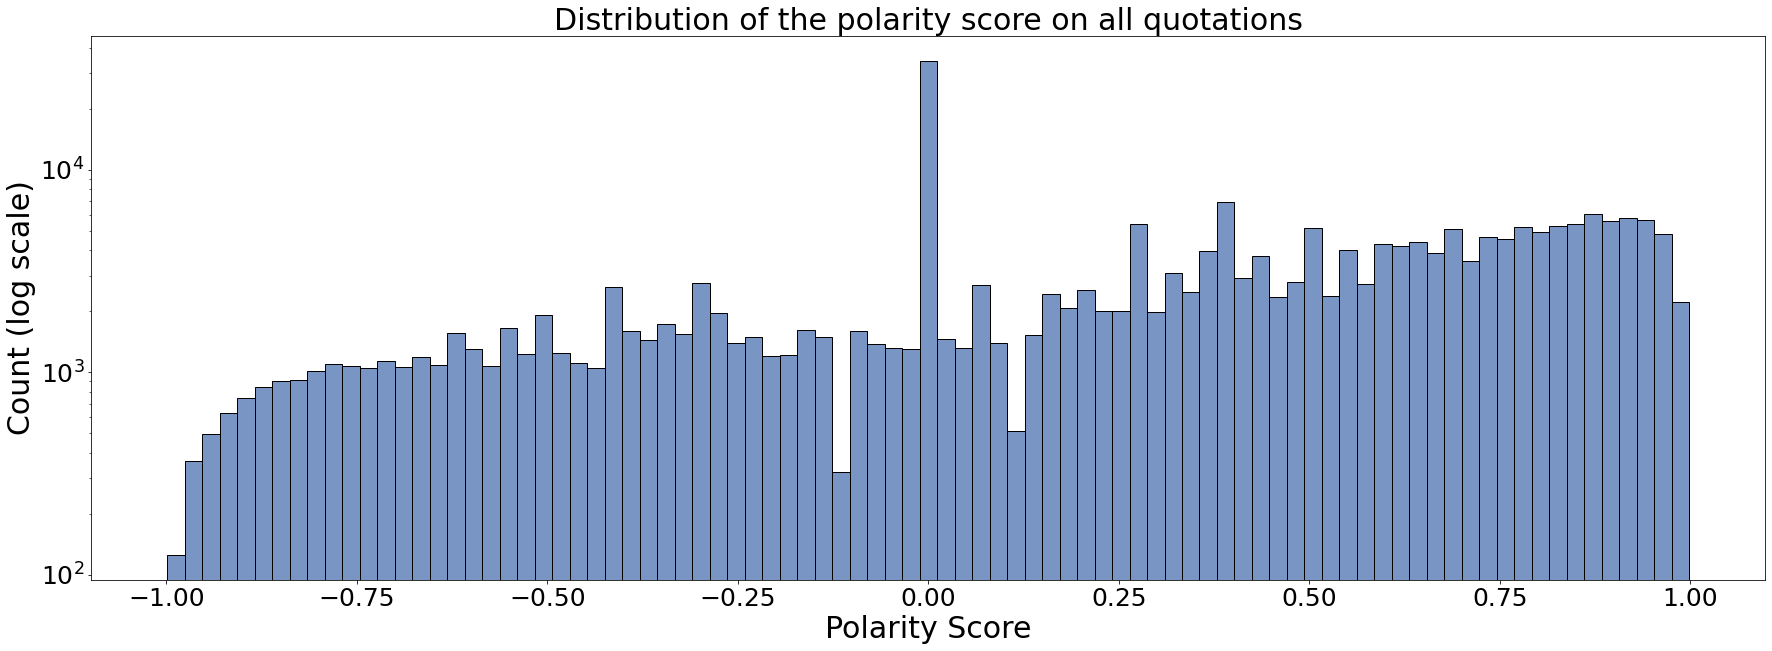

In [3]:

f,a = plt.subplots(1,1)


g= sns.histplot(data=df, x='compound')
g.set_xlabel("Polarity Score")
g.set_title("Distribution of the polarity score on all quotations")
g.set_yscale('log')
g.set_ylabel('Count (log scale)')


plt.savefig(fname="figs/total_polarity_distribution.png",dpi=300)

In [4]:
df.compound.describe()

count    243630.000000
mean          0.279800
std           0.496253
min          -0.998400
25%           0.000000
50%           0.361200
75%           0.718400
max           0.998800
Name: compound, dtype: float64

## Yearly observations

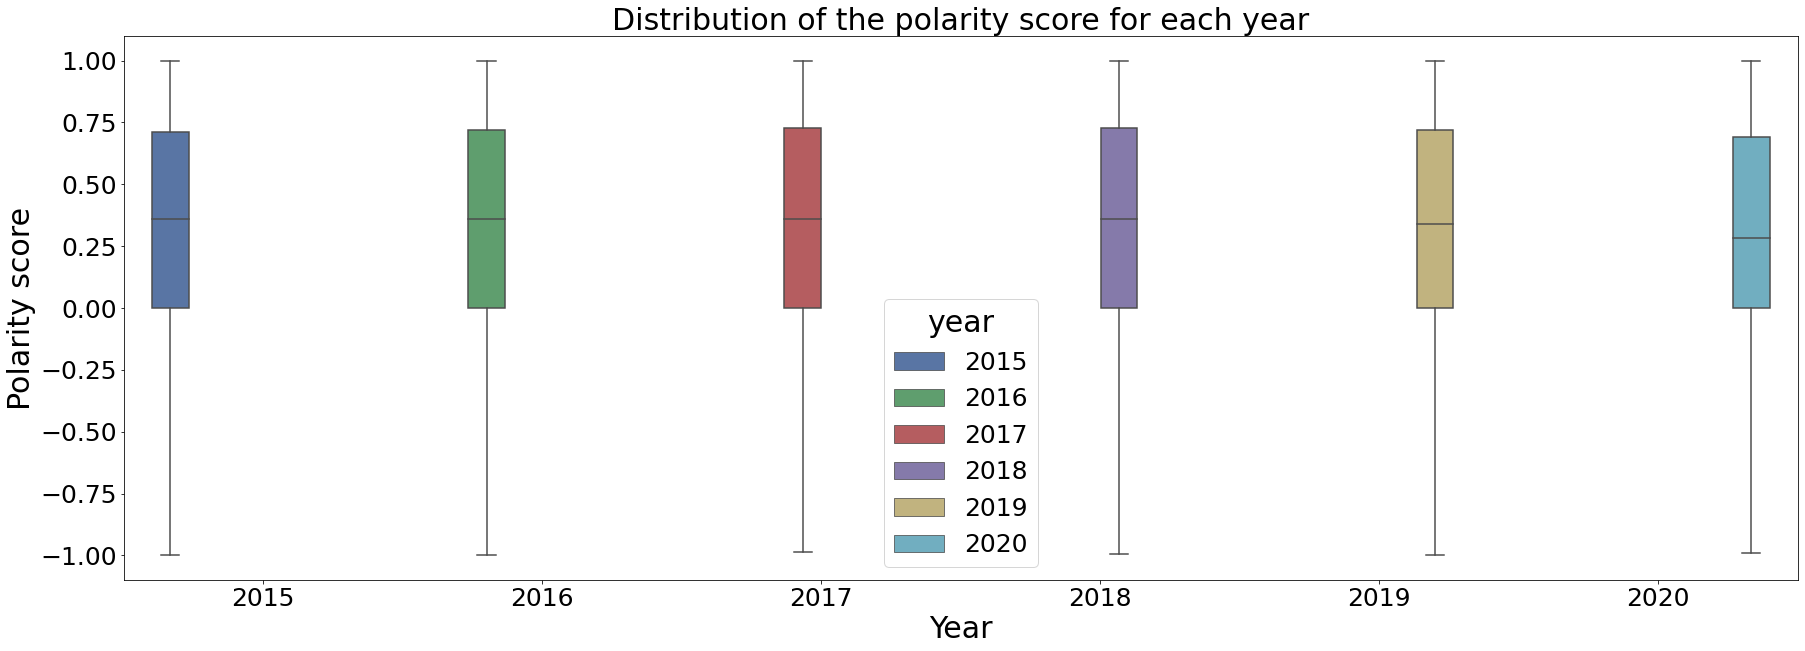

In [5]:
f,a = plt.subplots(1,1)

g= sns.boxplot(x='year', y='compound', data=df, hue ='year')

g.set_xlabel("Year")
g.set_title("Distribution of the polarity score for each year")
g.set_ylabel('Polarity score')

plt.savefig(fname="figs/boxplot_year.png",dpi=300)


Text(0.5, 1.0, 'Average polarity score over the years')

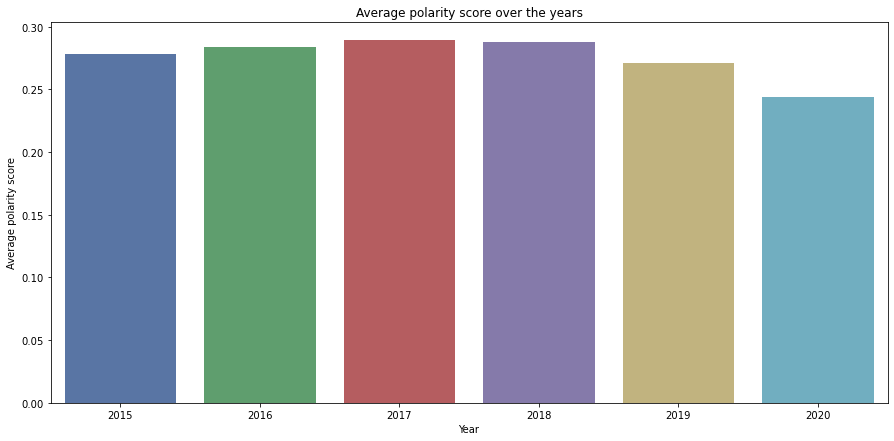

In [81]:
avg_scores = df.compound.groupby(by=df.year).mean()



g =sns.barplot(x=df.year.cat.categories, y=avg_scores)

g.set_xlabel("Year")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years")

## Monthly category

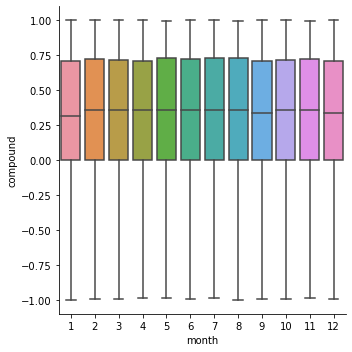

In [82]:
sns.catplot(x="month", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the months')

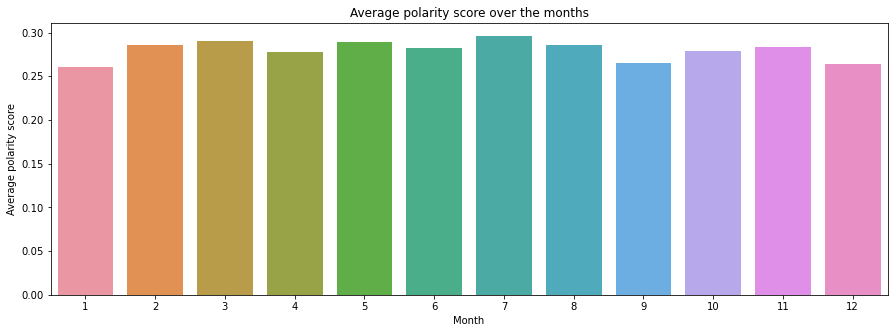

In [83]:
avg_scores = df.compound.groupby(by=df.month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.barplot(x=df.month.cat.categories, y=avg_scores)

g.set_xlabel("Month")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the months")

## Yearly-monthly category

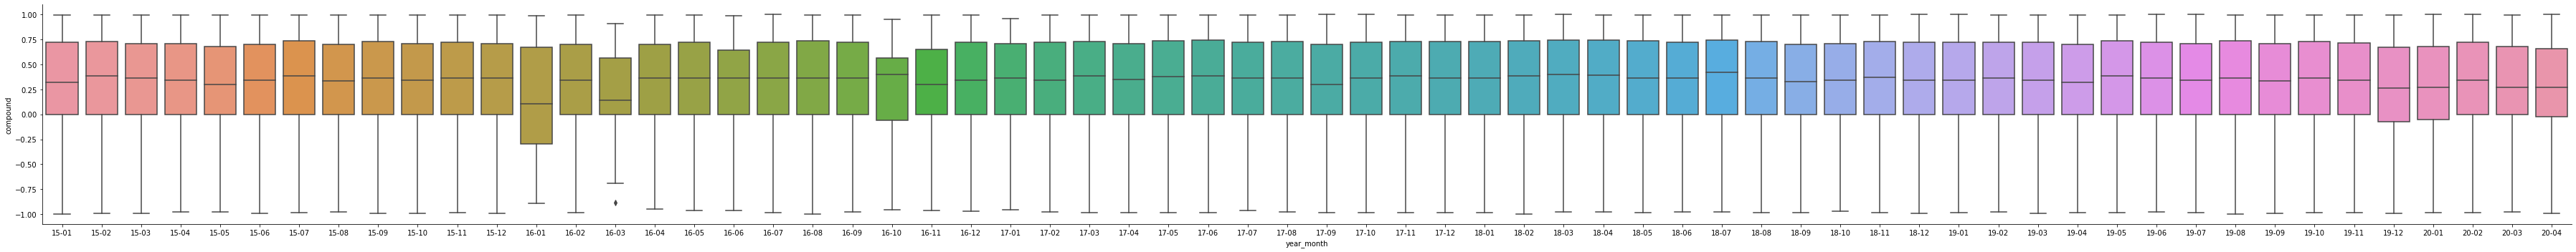

In [84]:
sns.catplot(x="year_month", y="compound", kind="box", data=df,height=5,aspect=10)

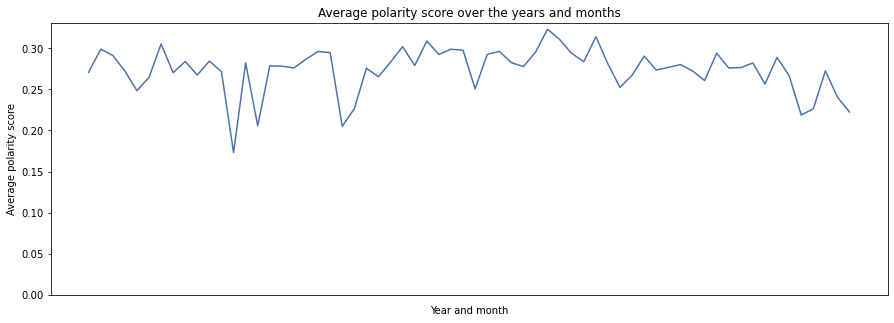

In [85]:
avg_scores = df.compound.groupby(by=df.year_month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=df.year_month.cat.categories, y=avg_scores)

g.set_xlabel("Year and month")
g.set_ylabel("Average polarity score")
g.set(xticklabels=[])
g.set_title("Average polarity score over the years and months")
g.set_ylim(0)
g.tick_params(bottom=False)

We notice a dip in November 2016

## Yearly-monthly-daily category

In [60]:
def plot_compound_year_month_day_time_series(df,filter=False, granularity=True, savepath=None):

    avg_scores = df.compound.groupby(by=df.year_month_day).mean()

    f,a = plt.subplots(1,1,figsize=(20,7))

    sel_indices = np.arange(len(avg_scores))
    avg_scores = avg_scores[sel_indices]

    if filter:
        avg_scores = avg_scores[:]
        avg_scores[(avg_scores < avg_scores.quantile(0.95)) & (avg_scores > avg_scores.quantile(0.05))] = 0

    if not(granularity):
        g =sns.lineplot(x=avg_scores.index, y=avg_scores)
        length = len(avg_scores)
        years= [2015,2016,2017,2018,2019,2020]
        step = length// len(years)
        xticklabels= [years[i // step] if (i%step == 0 and i // step < 6) else "" for i in range(length)]
        a.set_xticklabels(xticklabels)
        g.tick_params(bottom=False)

    else:
        plt.plot(avg_scores)
        xticklabels = np.unique(df.sort_values("date").apply(lambda e : str(e.year) + "/" + ("%02d" % e.month), axis=1).values)
        xticks = np.arange(len(avg_scores),step=len(avg_scores)//len(xticklabels))[:-1]
        a.set_xticks(xticks)
        a.set_xticklabels(xticklabels, rotation=45, fontsize=10)
   
    
    
    a.set_xlabel("Day")
    a.set_ylabel("Average polarity score")
    a.set_title("Average daily polarity score over the years")


    

    if savepath:
        plt.savefig(savepath,dpi=300, bbox_inches='tight')


Looking at this, it seems like that the narrative hasn't been increasingly polarized but it has know periods with very high polarity, let us investiage those time periods.

C:\Users\Harold\AppData\Local\Temp/ipykernel_7700/371379280.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(xticklabels)


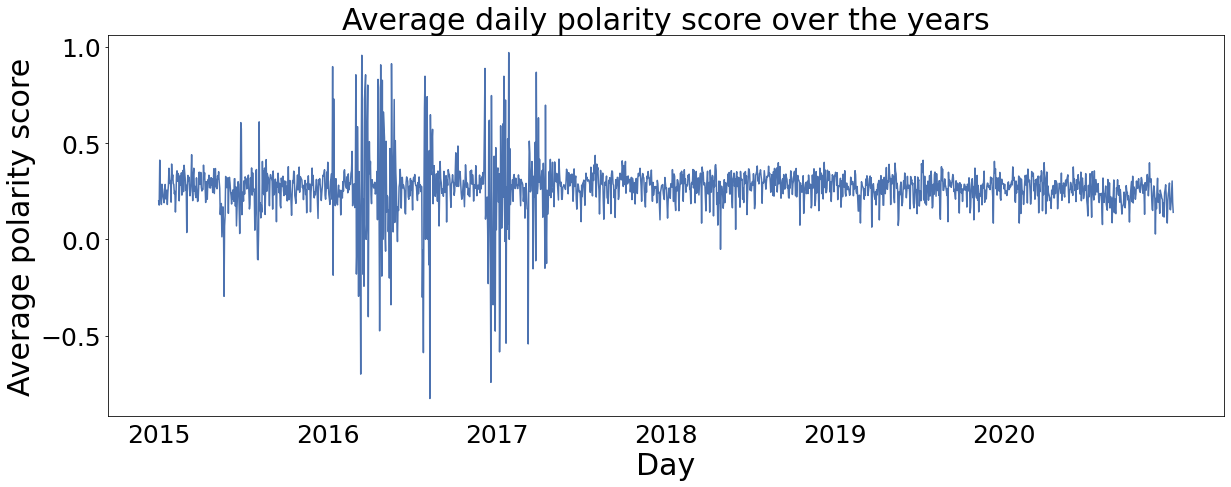

In [61]:
plot_compound_year_month_day_time_series(df,filter=False, granularity=False, savepath="figs/average_daily_polarity.png")

In [89]:
## finding the periods with the highest polarity scores

avg_scores = df.compound.groupby(by=df.year_month_day).mean()
sorted_scores = avg_scores.sort_values()

In [90]:
# let's find the top 5 periods of high polartiy in both directions

k = 5

for i in range(k):
    print(f"Date:{sorted_scores.index[i]} Polarity score: {sorted_scores[i]}\n")

for i in range(k):
    print(f"Date:{sorted_scores.index[-(i+1)]} Polarity score: {sorted_scores[-(i+1)]}\n")

Date:16-06-20 Polarity score: -0.8271

Date:16-10-16 Polarity score: -0.743

Date:16-01-20 Polarity score: -0.7003

Date:16-06-05 Polarity score: -0.58865

Date:16-11-04 Polarity score: -0.5849

Date:16-11-24 Polarity score: 0.9709

Date:16-01-22 Polarity score: 0.9568

Date:16-04-02 Polarity score: 0.913

Date:16-03-06 Polarity score: 0.9072

Date:15-11-20 Polarity score: 0.8979



It looks like 2016 is the period with the highest polarization around climate change. This could be linked with the 2016 USA Election which was highly polarized.

Let's investigate.

## Analysis on particular subjects

#### Most negative and positive dates

In [3]:
dummies_avg_year_month_day = df[dummies_col + ['compound']].groupby(by=df.year_month_day).mean()

In [4]:
sorted_dummies = dummies_avg_year_month_day.sort_values(by='compound')

Let's print the specific subjects that occur during highly polarized days

In [5]:
# let's find the top 5 periods of high polartiy in both directions

k = 5
offset = 0
negative_index = []
positive_index= []

print("Negative headlines\n")

for i in range(k):
    index = sorted_dummies[dummies_col].iloc[i+offset].argmax()
    subject = dummies_col[index]
    negative_index.append(sorted_dummies.index[i+offset])
    print(f"Date:{ sorted_dummies.index[i]}\tPolarity score: {sorted_dummies.iloc[i,-1]:.3f}\tSubject: {subject}\n")


print("Positive headlines\n")
for i in range(k):
    index = sorted_dummies[dummies_col].iloc[-(i+1+offset)].argmax()    
    subject = dummies_col[index]
    positive_index.append(sorted_dummies.index[-(i+1+offset)])
    print(f"Date: {sorted_dummies.index[-(i+1)]}\tPolarity score: {sorted_dummies.iloc[-(i+1),-1]:.3f}\tSubject: {subject}\n")

Negative headlines

Date:16-06-20	Polarity score: -0.827	Subject: climate

Date:16-10-16	Polarity score: -0.743	Subject: climate

Date:16-01-20	Polarity score: -0.700	Subject: fuel

Date:16-06-05	Polarity score: -0.589	Subject: climate

Date:16-11-04	Polarity score: -0.585	Subject: gas

Positive headlines

Date: 16-11-24	Polarity score: 0.971	Subject: climate

Date: 16-01-22	Polarity score: 0.957	Subject: carbon

Date: 16-04-02	Polarity score: 0.913	Subject: energy

Date: 16-03-06	Polarity score: 0.907	Subject: atmosphere

Date: 15-11-20	Polarity score: 0.898	Subject: earth



## Exploration on given topics

### Most negative and positive topics

In [8]:
topic_scores = {}
for topic in dummies_col:
    score = df[df[topic] ==1].compound.mean()
    topic_scores[topic] = score


topic_scores = dict(sorted(topic_scores.items(), key=lambda x:x[1]))

print(topic_scores)

{'wildfires': -0.047308760683760706, 'anthropocene': -0.020696551724137934, 'desertification': 0.004715957446808514, 'deforestation': 0.035876936619718316, 'typhoon': 0.04489308176100633, 'glacier': 0.05125714285714279, 'extinction': 0.057414370932754866, 'hurricane': 0.06515053837342501, 'extinct': 0.06870967741935498, 'drought': 0.07054409985844874, 'ozone': 0.09818254658385098, 'aerosol': 0.11277921146953411, 'permafrost': 0.11489788732394367, 'petrol': 0.11995368185516621, 'coal': 0.13557345915659066, 'sequestration': 0.13665654952076672, 'precipitation': 0.1433770053475934, 'coral': 0.14386637168141617, 'methane': 0.1727026939655173, 'anthropogenic': 0.1781861445783133, 'climate': 0.1813947710724785, 'fossil': 0.18997462395543183, 'earth': 0.20246368834469256, 'cryosphere': 0.21983076923076925, 'fuel': 0.22515229113442392, 'recycling': 0.24352689543241315, 'gases': 0.24759461538461527, 'gas': 0.25034344877607045, 'emission': 0.29901284390063104, 'greenhouse': 0.29996436950146654, 

### Polemic topics

In [9]:
topic_variances = []
topic_kurtosis = []

# looking to classify the variance and excess kurtosis of the daily polarity scores over 5 years for each topic
# we'll filter out topics that appear too little times (threshold at 100)

size_threshold = 500

for topic in dummies_col:
    new_df = df[df[topic] == 1]
    avg_scores = new_df.compound.groupby(by=new_df.year_month_day).mean()
    if not pd.isna(avg_scores.std()) and (len(new_df) > size_threshold):
        topic_variances.append((avg_scores.std(),topic, len(new_df)))
        topic_kurtosis.append((avg_scores.kurt(),topic, len(new_df)))

topic_kurtosis.sort(reverse=True)
topic_variances.sort(reverse=True)

In [10]:
def plot_compound_year__month_day_distribution(df):
    avg_scores = df.compound.groupby(by=df.year_month_day).mean()
    f,x = plt.subplots(1,1,figsize=(20,7))

    g = sns.histplot(x=avg_scores,bins="auto",kde=True)
    g.set_xlabel("Average daily polarity score")
    g.set_ylabel("Count")
    g.set_title("Distribution of average daily polarity score over the years")

### Comparison of polemic and non-polemic topics

We need to be able to decide whether a given topic is polemic/ controversial. Looking at the definition of **controversy** from Werriam-Webster: "a discussion marked especially by the expression of opposing views".

Therefore, a topic in which the daily polarity score always hovers around the same level, i.e its mean, would be considered not controversial. Whereas a topic where the daily polarity score tends to swing between -1 and 1, can be considered as a topic where there is expression of opposing views or that a given view is expressed in a variety of way (alarmist against hopeful).

Therefore, examining the empirical variance of the daily average polarity score of a given topic seems like a reasonable heuristic.

In [12]:
k = 5
polemic_topics = [tup[1] for tup in topic_variances[:k]]
not_polemic_topics = [tup[1] for tup in topic_variances[-k:]]

In [13]:
polemic_topics

['wildfires', 'deforestation', 'ecosystem', 'ozone', 'nuclear']

In [29]:
for topic in polemic_topics:
    new_df = df[df[topic] ==1].sort_values(by='compound', ascending = False)

    k=1
    print(new_df.quotation.head(k).to_markdown(), new_df.speaker.head(k))

|        | quotation                                                                                                                                                                                                                                                                                                                                                                                                                       |
|-------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 126579 | whether responding to storms like harvey or wildfires in west texas our state s first responders go above and beyond the call of du

In [14]:
not_polemic_topics

['earth', 'climate', 'gas', 'sustainable', 'energy']

In [15]:
def plot_multiple_topics(df,list_topics, polemic):
    
    k = len(list_topics)
    dim = [k//2 if k%2 == 0 else (k//2) + 1][0] 
    f, ax = plt.subplots(dim,2, figsize=(30,15) ,gridspec_kw={'wspace':0.2, 'hspace':1})
    s = "P" if polemic else "Not p"
    plt.suptitle(f"{s}olemic topics distributions")
    for i in range(k):
        new_df = df[df[list_topics[i]] == 1]
        avg_scores = new_df.compound.groupby(by=new_df.year_month_day).mean()
        j,l = divmod(i,2)
        g = sns.histplot(x=avg_scores,bins="auto",kde=True, ax= ax[j][l])
        g.set_xlabel("Average daily polarity score")
        g.set_ylabel("Count")
        g.set_title(f"{str.capitalize(list_topics[i])}")
        #g.set_title("Distribution of average daily polarity score over the years")

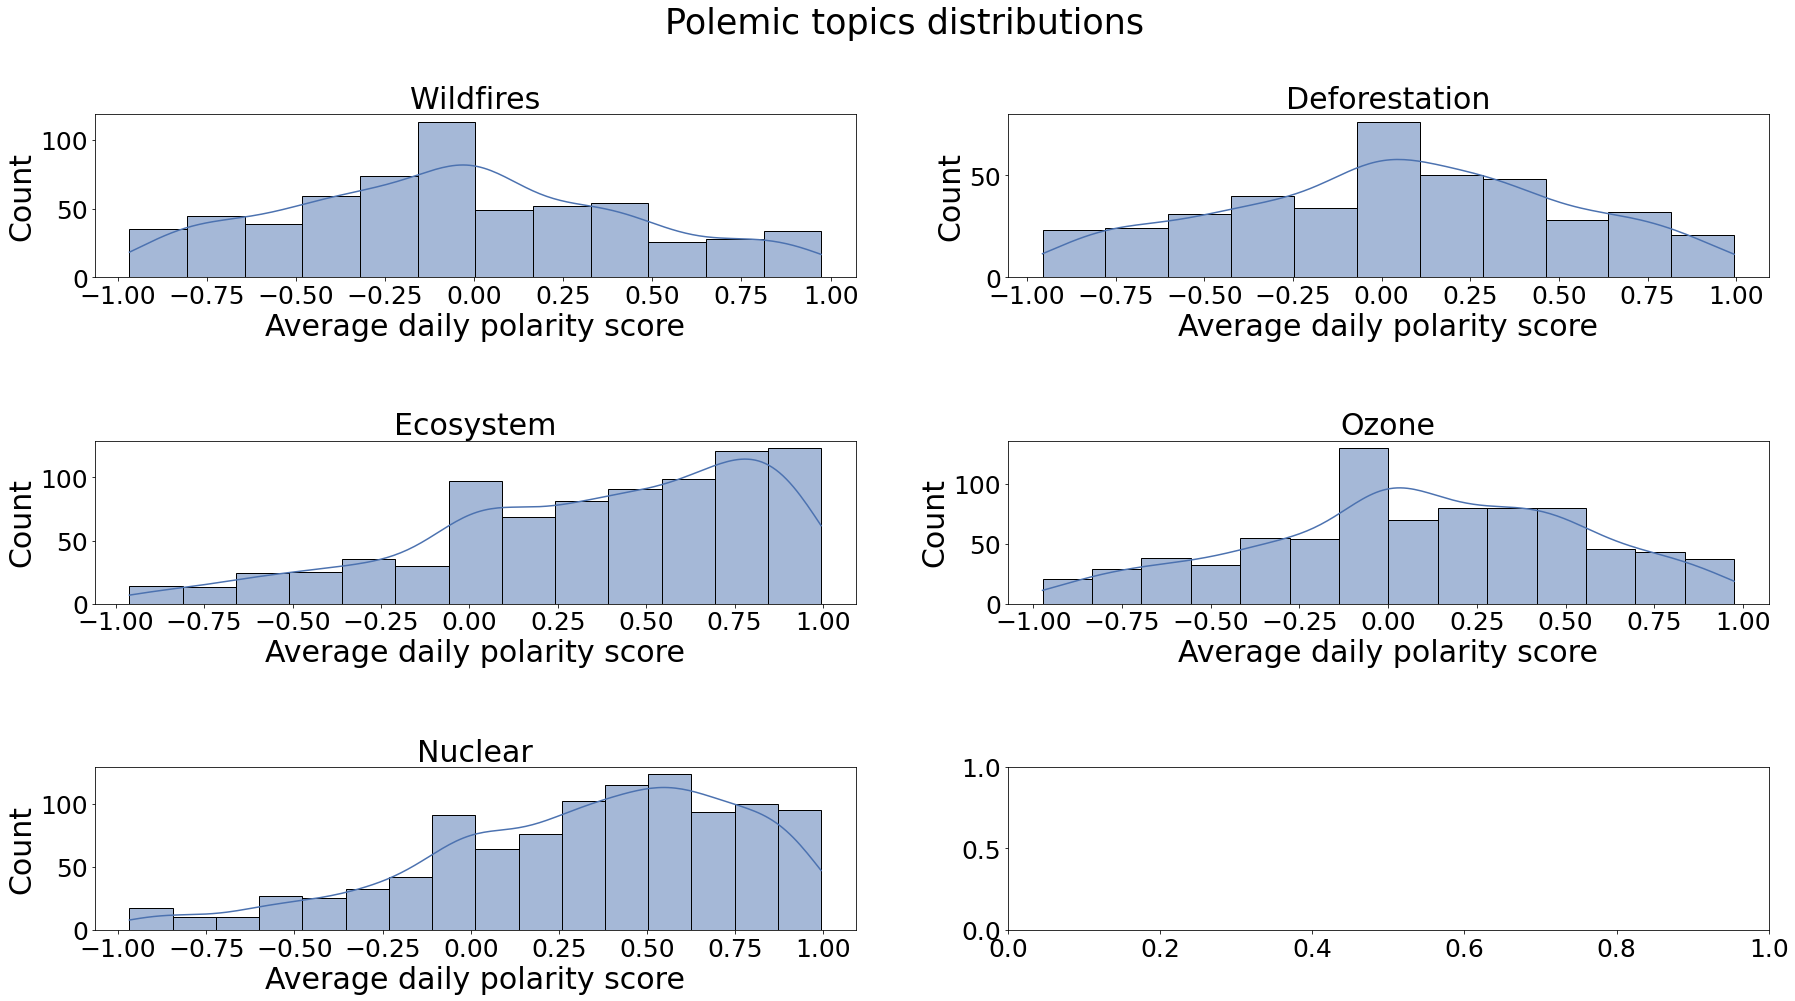

In [16]:
plot_multiple_topics(df,list_topics=polemic_topics,polemic=True)


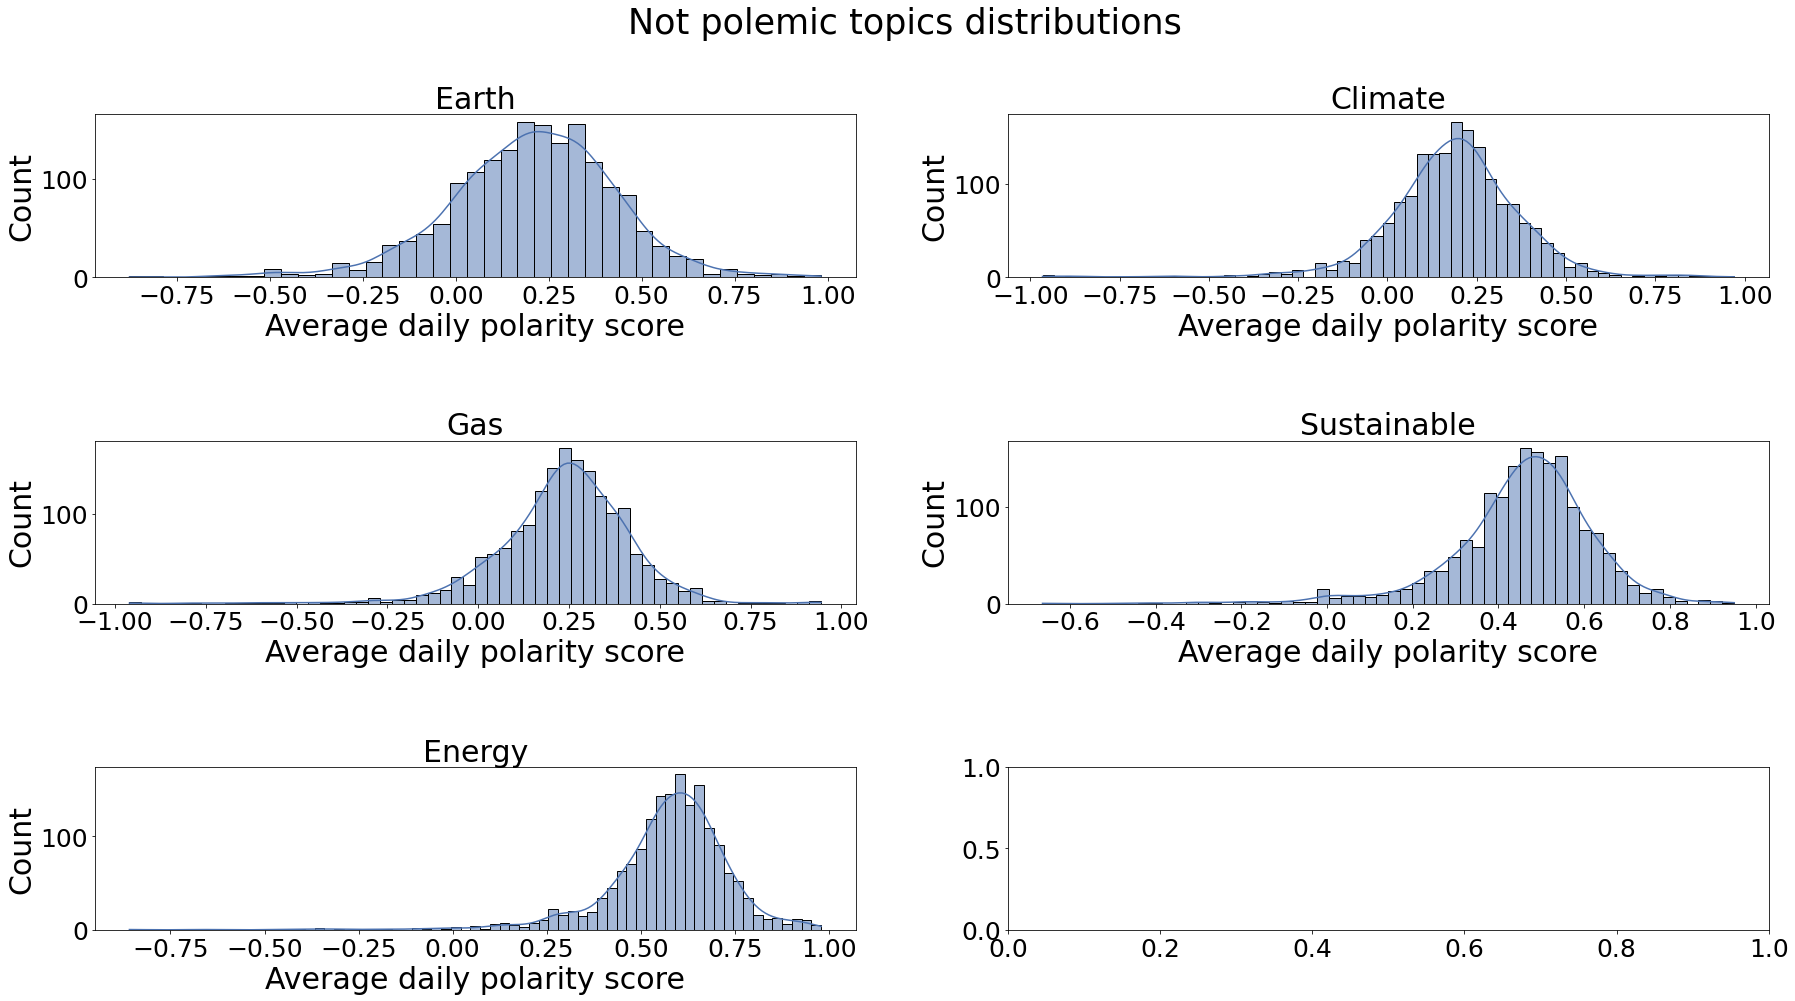

In [17]:
plot_multiple_topics(df,list_topics=not_polemic_topics,polemic=False)

C:\Users\Harold\AppData\Local\Temp/ipykernel_12248/134616466.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set(xticklabels=ticks_labels)


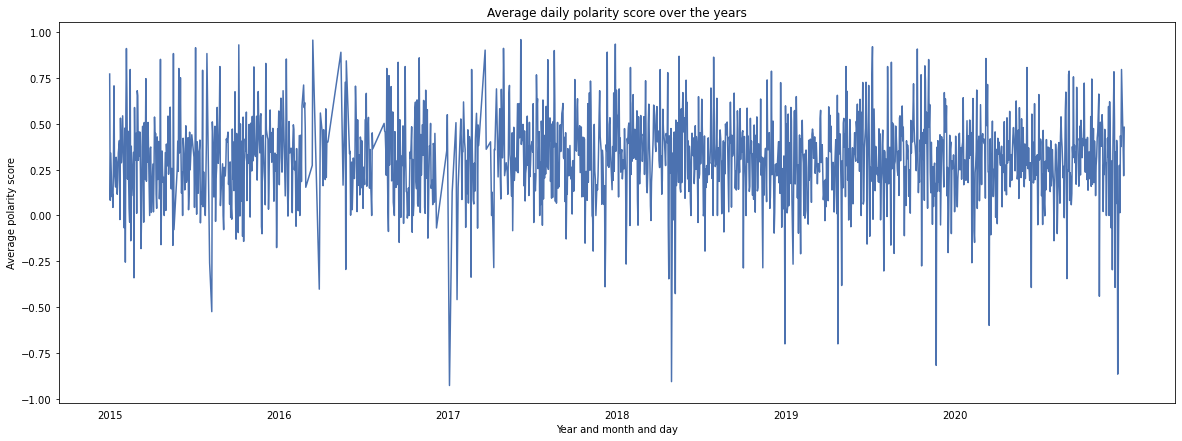

In [17]:
plot_compound_year_month_day_time_series(df[df.carbon == 1])

## Time series analysis on polemic topics

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp = df[df.carbon==1]
avg_scores = temp.compound.groupby(by=temp.year_month_day).mean()

result_mul = seasonal_decompose(temp.compound, model='additive',period=30)


<AxesSubplot:ylabel='trend'>

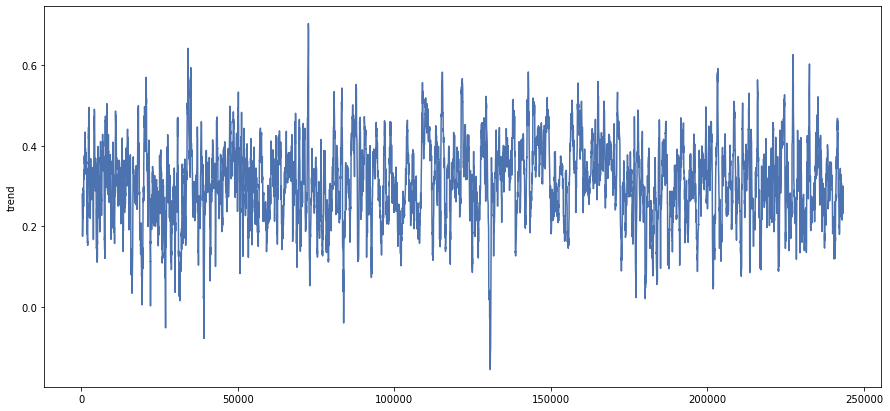

In [29]:
sns.lineplot(x=result_mul.trend.index, y = result_mul.trend)